In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import LedoitWolf
from xgboost import XGBRegressor
import cvxpy as cp
import matplotlib.pyplot as plt

Goal: 

Construct and evaluate multiple portfolio allocation strategies using real market data, combining:

+ Traditional optimization techniques

+ Machine learning models

+ Risk-adjusted performance comparisons

+ Quarterly rebalancing over a multi-year period

Data Overview: 
+ Assets: 10 large-cap S&P 500 stocks (e.g., AAPL, MSFT, BRK-B)

+ Source: Yahoo Finance via yfinance

+ Period: 2015–2025

+ Frequency: Monthly data

+ Returns: Computed as month-over-month percentage changes from adjusted prices



In [2]:
# 1. Download Historical Data

tickers = ['AAPL', 'MSFT', 'AMZN', 'NVDA', 'GOOGL', 'META', 'TSLA', 'BRK-B', 'UNH', 'JPM']

data = yf.download(tickers, start='2015-01-01', end='2025-06-01', auto_adjust=True)
data = data['Close']
monthly_prices = data.resample('M').last()
monthly_returns = monthly_prices.pct_change(fill_method=None).dropna()

# 2. Rebalancing Setup

rebalance_dates = monthly_returns.index[::3]
weights_history = pd.DataFrame(index=monthly_returns.index, columns=tickers)


[*********************100%***********************]  10 of 10 completed


Methods Compared: 

+ Mean-Variance Optimization (MVO) – Classical:

    - Allocates weights to maximize the Sharpe ratio based on historical mean returns and sample covariance.

    - Rebalanced quarterly using a 12-month lookback window.

    - Known to be highly sensitive to noisy inputs.

    - Outcome: Performed poorly due to unstable inputs and lack of constraints.

+ Improved MVO (Shrinkage + Constraints):

    - Enhances classical MVO by:

    - Using Ledoit-Wolf shrinkage to stabilize the covariance matrix.

    - Adding realistic constraints:

        * No short-selling (weights ≥ 0)

        * Max 20% allocation per asset  

        * Solves using convex optimization (cvxpy)

        * More robust to outliers and estimation errors.

        * Outcome: Substantially improved risk-adjusted performance and more stable allocation.

+ Equal-Weighted Portfolio:

    - Simple benchmark: 10% allocated to each stock.

    - No assumptions, no re-optimization.

    - Outcome: Strong Sharpe ratio due to diversification and stability.

+ Random Forest:

    - Uses a 3-month rolling window of past returns to predict next-month returns.

    - Allocates more weight to stocks with higher predicted returns.

    - Captures nonlinear relationships but can be more volatile.

    - Outcome: Higher returns than Equal-Weight, with moderate increase in volatility.

+ XGBoost:

    - Gradient-boosted tree model, known for strong predictive performance.

    - Similar setup to Random Forest.

    - Outcome: Balanced trade-off between return and risk, delivering competitive Sharpe ratio.

Rebalancing Framework:

+ Portfolios are rebalanced every 3 months

+ Each rebalance uses the most recent 12 months of data

+ Ensures strategies adapt over time without excessive turnover

In [3]:
# 3. Mean-Variance Optimization

for date in rebalance_dates:
    window = monthly_returns.loc[:date].tail(12)
    if len(window) < 2:
        continue
    mu = window.mean()
    cov = window.cov()
    try:
        inv_cov = np.linalg.inv(cov.values)
        weights = inv_cov @ mu.values
        weights /= np.sum(weights)
        weights_series = pd.Series(weights, index=mu.index)
    except:
        weights_series = pd.Series(1 / len(mu), index=mu.index)
    weights_history.loc[date] = weights_series

weights_history = weights_history.ffill()
mvo_returns = (monthly_returns * weights_history).sum(axis=1)
mvo_cum = (1 + mvo_returns).cumprod()

# 3b. Improved MVO with Shrinkage + Constraints

weights_history_improved = pd.DataFrame(index=monthly_returns.index, columns=tickers)

for date in rebalance_dates:
    window = monthly_returns.loc[:date].tail(12)
    if len(window) < 2:
        continue

    mu = window.mean().values
    cov = LedoitWolf().fit(window).covariance_
    n_assets = len(tickers)
    w = cp.Variable(n_assets)

    risk = cp.quad_form(w, cov)
    ret = mu @ w
    objective = cp.Maximize(ret - 0.5 * risk)
    constraints = [cp.sum(w) == 1, w >= 0, w <= 0.2]

    problem = cp.Problem(objective, constraints)
    try:
        problem.solve()
        weights_series = pd.Series(w.value, index=tickers)
    except:
        weights_series = pd.Series(1 / n_assets, index=tickers)

    weights_history_improved.loc[date] = weights_series

weights_history_improved = weights_history_improved.ffill()
mvo_improved_returns = (monthly_returns * weights_history_improved).sum(axis=1)
mvo_improved_cum = (1 + mvo_improved_returns).cumprod()

# 4. Equal-Weighted Benchmark

equal_weights = pd.Series(1 / len(tickers), index=tickers)
equal_returns = (monthly_returns * equal_weights).sum(axis=1)
equal_cum = (1 + equal_returns).cumprod()

# 5. Machine Learning Features

lookback = 3
X, y = [], []

for i in range(lookback, len(monthly_returns) - 1):
    X.append(monthly_returns.iloc[i - lookback:i].values.flatten())
    y.append(monthly_returns.iloc[i + 1].values)

X = np.array(X)
y = np.array(y)

if X.shape[0] == 0:
    raise ValueError("Not enough data to create machine learning features.")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Random Forest Prediction

rf_preds = []
for i in range(len(tickers)):
    model = RandomForestRegressor(n_estimators=100, random_state=17)
    model.fit(X_scaled, y[:, i])
    rf_preds.append(model.predict(X_scaled))

rf_latest = np.array([p[-1] for p in rf_preds])
rf_weights = rf_latest / np.sum(rf_latest)
rf_returns = (monthly_returns.iloc[lookback+1:] * rf_weights).sum(axis=1)
rf_cum = (1 + rf_returns).cumprod()

# 7. XGBoost Prediction

xgb_preds = []
for i in range(len(tickers)):
    model = XGBRegressor(n_estimators=25, max_depth=2, learning_rate=0.1, random_state=17, verbosity=0)
    model.fit(X_scaled, y[:, i])
    xgb_preds.append(model.predict(X_scaled))

xgb_latest = np.array([p[-1] for p in xgb_preds])
xgb_weights = xgb_latest / np.sum(xgb_latest)
xgb_returns = (monthly_returns.iloc[lookback+1:] * xgb_weights).sum(axis=1)
xgb_cum = (1 + xgb_returns).cumprod()


Summary of Findings: 

+ Improved MVO outperforms classical MVO due to regularization and realistic constraints.

+ Equal-weighted portfolio remains a robust baseline.

+ ML-based strategies show promise, especially when combined with classical methods.

+ Classical MVO is vulnerable to input instability and overconcentration.

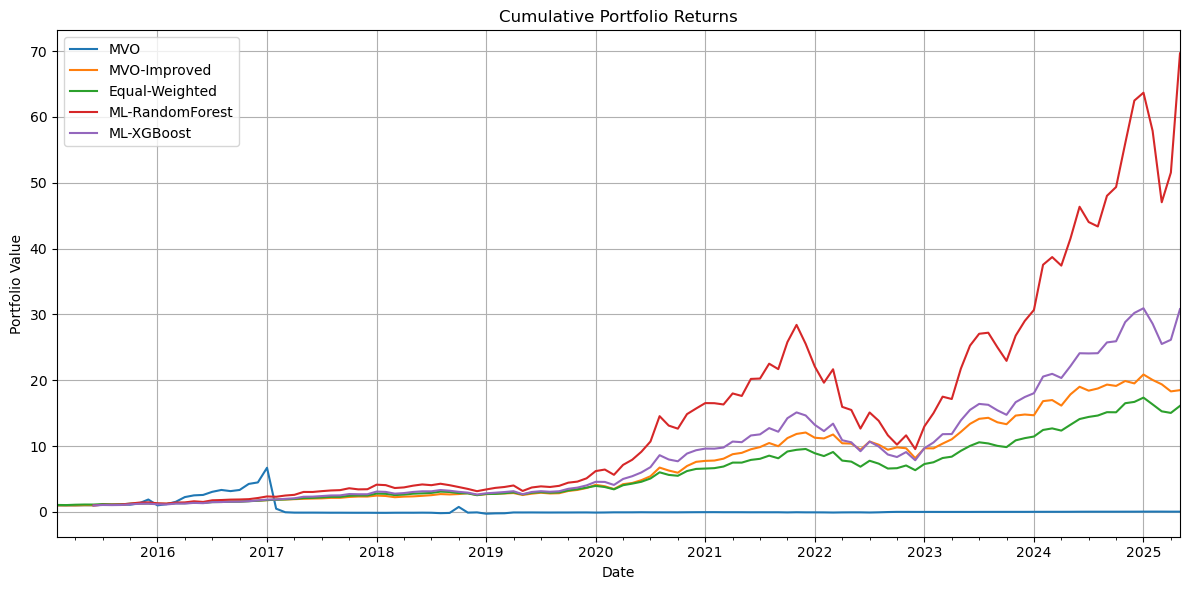


 Performance Metrics:

                    MVO  MVO-Improved  Equal-Weighted  ML-RandomForest  \
Annual Return -0.563016      0.310095        0.293308         0.507666   
Volatility     2.777463      0.225051        0.208307         0.397694   
Sharpe        -0.202709      1.377887        1.408055         1.276524   

               ML-XGBoost  
Annual Return    0.386048  
Volatility       0.281477  
Sharpe           1.371505  


In [4]:
# 8. Performance Metrics

def metrics(returns):
    return pd.Series({
        'Annual Return': returns.mean() * 12,
        'Volatility': returns.std() * np.sqrt(12),
        'Sharpe': (returns.mean() / returns.std()) * np.sqrt(12)
    })

df_metrics = pd.DataFrame({
    'MVO': metrics(mvo_returns),
    'MVO-Improved': metrics(mvo_improved_returns),
    'Equal-Weighted': metrics(equal_returns),
    'ML-RandomForest': metrics(rf_returns),
    'ML-XGBoost': metrics(xgb_returns)
})

# 9. Plot Cumulative Returns

cum_df = pd.DataFrame({
    'MVO': mvo_cum,
    'MVO-Improved': mvo_improved_cum,
    'Equal-Weighted': equal_cum,
    'ML-RandomForest': rf_cum,
    'ML-XGBoost': xgb_cum
})

cum_df.plot(figsize=(12, 6), title="Cumulative Portfolio Returns")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()

print("\n Performance Metrics:\n")
print(df_metrics)




Future directions: 

+ Expand asset universe to full S&P 500

+ Incorporate forecasted macroeconomic indicators into ML models

+ Explore ensemble methods